In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
def generate_dataset(num_samples, num_features, std, seed=0):
    """
    generate dataset of features and target

    Args:
        num_samples: number of samples
        num_features: number of features
        std: std of normal noise added to the data
        seed: random seed
    
    Output:
        df: dataframe containing the data of features and target
        idx: index of the feature that correlates with the target
        
    """
    # set random seed
    np.random.seed(1234567890)
    
    # first, generate uniformly random number between 0 and 1
    x = np.random.rand(num_samples, num_features)
    
    # set random seed
    np.random.seed(seed)
    
    # copy the first feature as the target variable
    y = x[:, 0].copy()
    
    # add the normally distributed noise to the each data
    x += np.random.normal(size=(num_samples, num_features), scale=std)
    
    # concat x and y to make a dataframe
    Xy = np.hstack((y[:, np.newaxis], x))

    # column names for the features
    colsx = ['x_{:0>2d}'.format(i) for i in range(x.shape[1])]
    df = pd.DataFrame(Xy, columns=['y', *colsx])
    return df

num_features = 2
num_samples = 1000
std = 1000
df = generate_dataset(num_samples, num_features, std, seed=0)

# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# ax.scatter(x[:, 0], x[:, 1], s=2)
# plt.show()

print(df.shape)
df.head()

(1000, 3)


,y,x_00,x_01
0,0.618795,1764.671141,400.748832
1,0.888684,979.626668,2241.784854
2,0.457567,1868.015558,-976.499692
3,0.267064,950.355481,-150.361102
4,0.540095,-102.678757,411.136024


# First case: num_features = 2

In [13]:
def compute_correlations_over_seeds(num_rounds, num_features, num_samples, std):
    """
    compute correlations between each feature and the target for a given std

    Args:
        num_samples: number of samples
        num_features: number of features
        num_rounds: number of rounds to compute the correlations with a given seed
        std: std of normal noise added to the data
    
    Output:
        corr: (num_rounds, num_features)
              computed correlations
        
    """
    corr = np.zeros((num_rounds, num_features))
    ans = np.zeros(num_rounds)
    for j in range(num_rounds):
        # use j as the seed for this round
        df = generate_dataset(num_samples, num_features, std, seed=j)
        corr[j, :] = df.corr().iloc[0, 1:].values
    del df
    return corr

def simulate_over_stds(num_rounds, num_features, num_samples, stds):
    """
    compute correlations between each feature and the target for a given std

    Args:
        num_samples: number of samples
        num_features: number of features
        num_rounds: number of rounds to compute the correlations with a given seed
        stds: 'std's of normal noise added to the data
    
    Output:
        precs: (num_stds,)
               computed precision for each std
        corr: (num_stds, num_rounds, num_features)
              computed correlations
        
    """
    num_stds = stds.shape[0]
    precs = np.zeros(num_stds)
    corrs = np.zeros((num_stds, num_rounds, num_features))
    for i, std in enumerate(stds):
        corr = compute_correlations_over_seeds(num_rounds, num_features, num_samples, std)
        # take the feature that correlates the most to the target as the answer
        precs[i] = (np.argmax(corr, axis=1) == 0).sum() / num_rounds
        corrs[i, :, :] = corr
    return precs, corrs

stds = np.power(2., np.arange(20))
num_rounds = 1000
num_samples = 10000
num_features = 2
precs, corrs = simulate_over_stds(num_rounds, num_features, num_samples, stds)

### Plot std vs precsion
### Here, we expected precision converge to 0.5.

[1.    1.    1.    0.997 0.909 0.771 0.654 0.583 0.551 0.53  0.518 0.513
 0.512 0.512 0.512 0.512 0.512 0.512 0.512 0.512]


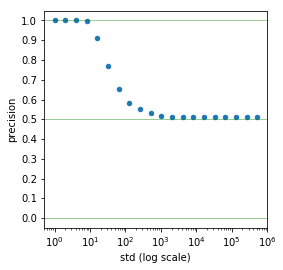

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(stds, precs, s=20)
ax.set_xscale('log')
ax.set_ylim((-0.05, 1.05))
ax.set_yticks(np.arange(0, 1.1, 0.1))
xmin, xmax = ax.get_xlim()
ax.hlines(y=[0.0, 0.5, 1.0], xmin=xmin, xmax=xmax, color='green', linewidth=1, alpha=0.4)
ax.set_xlim((xmin, xmax))
ax.set_xlabel('std (log scale)')
ax.set_ylabel('precision')
print(precs)
plt.show()

# Can we tell which feature correlates with the target for a given dataset?

,y,x_00,x_01
0,0.618795,1807.008397,410.352605
1,0.888684,1003.116379,2295.566291
2,0.457567,1912.836949,-999.954361


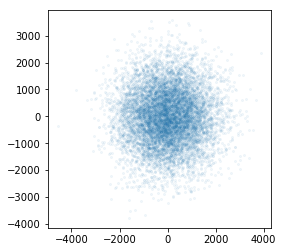

In [29]:
std = np.power(2., 10)
num_samples = 10000
num_features = 2

df = generate_dataset(num_samples, num_features, std)
display(df.head(3))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(df['x_00'].values, df['x_01'].values, s=4, alpha=0.05)
plt.show()

In [42]:
num_iters = 10000
corrs = np.zeros((num_iters, num_features))
for i in range(num_iters):
    df_ = df.sample(frac=1., replace=True, random_state=i)
    corrs[i, :] = df_.corr().iloc[0, 1:].values

colsx = ['x_{:0>2d}'.format(i) for i in range(num_features)]
df_corr = pd.DataFrame(corrs, columns=colsx)

In [43]:
df_corr.mean(axis=0)

x_00    0.003129
x_01   -0.007184
dtype: float64

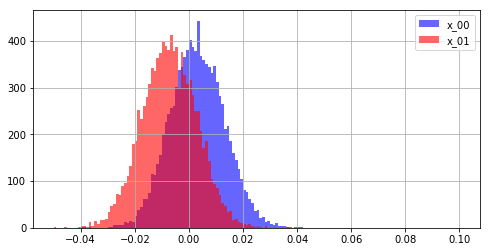

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
df_corr['x_00'].hist(bins=np.linspace(-0.05, 0.1, 151), color='blue', ax=ax, alpha=0.6)
df_corr['x_01'].hist(bins=np.linspace(-0.05, 0.1, 151), color='red', ax=ax, alpha=0.6)
plt.legend(['x_00', 'x_01'])
plt.show()

In [52]:
xl = df_corr['x_00'].quantile(q=0.025, interpolation='linear')
xu = df_corr['x_00'].quantile(q=0.975, interpolation='linear')
xm = df_corr['x_00'].mean()
print('{:5.4f}, {:5.3f}, {:5.4f}'.format(xl, xm, xu))

-0.0160, 0.003, 0.0228


In [53]:
xl = df_corr['x_01'].quantile(q=0.025, interpolation='linear')
xu = df_corr['x_01'].quantile(q=0.975, interpolation='linear')
xm = df_corr['x_01'].mean()
print('{:5.4f}, {:5.3f}, {:5.4f}'.format(xl, xm, xu))

-0.0267, -0.007, 0.0123


In [54]:
1/np.sqrt(1 + std**2)

0.0009765620343390458

In [55]:
df_corr['x_00'].std()

0.009966978329203858

In [56]:
df_corr['x_01'].std()

0.010018310576286734

In [57]:
df.head()

,y,x_00,x_01
0,0.618795,1807.008397,410.352605
1,0.888684,1003.116379,2295.566291
2,0.457567,1912.836949,-999.954361
3,0.267064,973.157603,-153.993675
4,0.540095,-105.156009,420.990388


In [58]:
df['x_00'].mean()

-10.237276886254008

In [59]:
df['x_00'].std()

1018.8486126841706

In [60]:
df['x_01'].mean()

3.614117936350407

In [61]:
df['x_01'].std()

1009.5634329809135